In [2]:
from astropy.table import Table, QTable, Column
import numpy as np
import astropy.units as u
from astropy.io import fits as pyfits
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.coordinates import SkyCoord
from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry
from astropy.io import ascii
from astropy.wcs import WCS
from scipy.stats import norm
import matplotlib.mlab as mlab

##-------------------------Importing Everything I Will Need-----------------------------------##

hdu = pyfits.open('C:/Users/dougl/Desktop/smcw2-nd-intbgsub.fits', ignore_missing_end=True)
w = WCS(hdu[0].header)


In [3]:
from astropy.io import ascii
catalog = Table.read('C:/Users/dougl/Desktop/asu(1).fit', format = 'fits')
print(catalog)

 RAJ2000    IDra    DEJ2000   Umag  e_Umag ... e_Imag Flag Jmag Hmag Ksmag
   deg       h        deg     mag    mag   ...  mag        mag  mag   mag 
--------- -------- --------- ------ ------ ... ------ ---- ---- ---- -----
 5.617095 0.374473 -74.89902  20.53  0.165 ...  0.048   10  nan  nan   nan
 5.617995 0.374533 -74.88598    nan    nan ...    nan    0  nan  nan   nan
 5.618685 0.374579 -74.89183 21.784  0.497 ...  0.149    0  nan  nan   nan
 5.618955 0.374597 -74.89297    nan    nan ...   0.26    0  nan  nan   nan
  5.61939 0.374626 -74.86275    nan    nan ...    nan    0  nan  nan   nan
  5.61969 0.374646 -74.89796    nan    nan ...    nan    0  nan  nan   nan
  5.62077 0.374718 -74.88685    nan    nan ...  0.283    0  nan  nan   nan
 5.622585 0.374839 -74.89294    nan    nan ...  0.321    0  nan  nan   nan
 5.622675 0.374845 -74.89507 20.146  0.164 ...  0.216    0  nan  nan   nan
 5.623395 0.374893 -74.89001 21.913  0.506 ...  0.331    0  nan  nan   nan
      ...      ...       

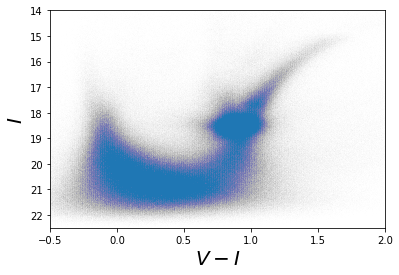

In [4]:
Vmag = catalog["Vmag"]
Imag = catalog["Imag"]
VImag = Vmag - Imag
plt.scatter(VImag, Imag, s=0.001, alpha=0.025)
plt.ylim(reversed(plt.ylim()))
plt.xlabel("$V-I$", fontsize=20)
plt.ylabel("$I$", fontsize=20)
plt.xlim(-0.5,2)
plt.ylim(22.5,14)
plt.show()

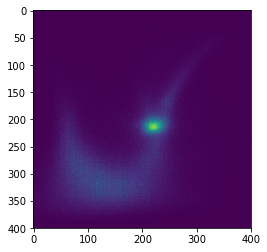

In [5]:
Vmag = catalog["Vmag"]
Imag = catalog["Imag"]
VImag = Vmag - Imag
NaNs1 = np.isnan(VImag)
NaNs2 = np.isnan(Imag)
VImag[NaNs1]= -9999
Imag[NaNs2] = -9999
bins = (400,400)
H1, xedges1, yedges1 = np.histogram2d(Imag, VImag, bins, range=[[14,22.5], [-0.5, 2]])
plt.imshow(H1)

In [6]:
ra_1=[]
dec_1=[]
Vmag_1=[]
for i in range(0,5156056):
    Vmag = catalog["Vmag"][i]
    Imag = catalog["Imag"][i]
    VImag = Vmag - Imag
    ra = catalog["RAJ2000"][i]
    dec = catalog["DEJ2000"][i]
    if -0.25 < VImag and VImag < 0.0 and 17 < Imag and Imag < 18:
        ra_1.append(ra)
        dec_1.append(dec)
        Vmag_1.append(Vmag)

loc_1 = Table()
loc_1['RAJ2000'] = ra_1
loc_1['DEJ2000'] = dec_1

In [7]:
positions_1 = SkyCoord(ra=loc_1['RAJ2000'] * u.deg, dec=loc_1['DEJ2000'] * u.deg, frame='fk5')
r=10 * u.arcsec
apertures_1 = SkyCircularAperture(positions_1, r)
phot_table_1 = aperture_photometry(hdu[0], apertures_1)

In [8]:
Flux_1 = phot_table_1['aperture_sum']
NUV_magnitude_1 = -2.5*np.log10(Flux_1) + 20.08

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


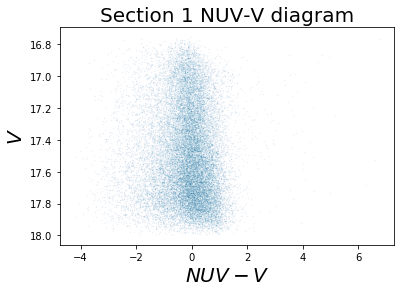

In [9]:
plt.scatter(NUV_magnitude_1 - Vmag_1, Vmag_1, s=0.03,alpha=0.2)
plt.ylim(reversed(plt.ylim()))
plt.xlabel("$NUV-V$", fontsize=20)
plt.ylabel("$V$", fontsize=20)
plt.title("Section 1 NUV-V diagram",fontsize=20)


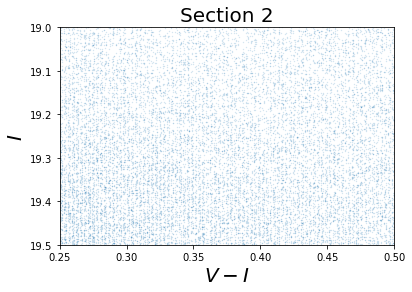

In [10]:
##---------------------------------SECTION 2---------------------------------------##
plt.scatter(catalog["Vmag"] - catalog["Imag"], catalog["Imag"], s=0.1,alpha=0.25)
plt.ylim(reversed(plt.ylim()))
plt.xlabel("$V-I$", fontsize=20)
plt.ylabel("$I$", fontsize=20)
plt.xlim(0.25,0.5)
plt.ylim(19.5,19)
plt.title("Section 2", fontsize=20)

In [11]:
ra_2=[]
dec_2=[]
Vmag_2=[]
for i in range(0,5156056):
    Vmag = catalog["Vmag"][i]
    Imag = catalog["Imag"][i]
    VImag = Vmag - Imag
    ra = catalog["RAJ2000"][i]
    dec = catalog["DEJ2000"][i]
    if 0.25 < VImag and VImag < 0.5 and 19 < Imag and Imag < 19.5:
        ra_2.append(ra)
        dec_2.append(dec)
        Vmag_2.append(Vmag)

loc_2 = Table()
loc_2['RAJ2000'] = ra_2
loc_2['DEJ2000'] = dec_2

In [12]:
positions_2 = SkyCoord(ra=loc_2['RAJ2000'] * u.deg, dec=loc_2['DEJ2000'] * u.deg, frame='fk5')
apertures_2 = SkyCircularAperture(positions_2, r)
phot_table_2 = aperture_photometry(hdu[0], apertures_2)
Flux_2 = phot_table_2['aperture_sum']
NUV_magnitude_2 = -2.5*np.log10(Flux_2) + 20.08

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in log10


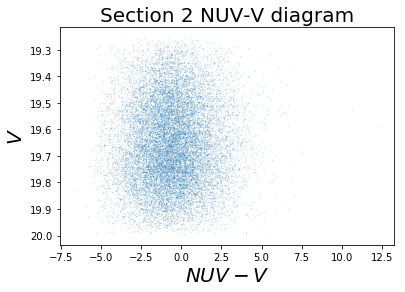

In [13]:
plt.scatter(NUV_magnitude_2 - Vmag_2, Vmag_2, s=0.1,alpha=0.25)
plt.ylim(reversed(plt.ylim()))
plt.xlabel("$NUV-V$", fontsize=20)
plt.ylabel("$V$", fontsize=20)
plt.title("Section 2 NUV-V diagram", fontsize=20)

In [14]:
##--------------------------SECTION 3---------------------------------##
ra_3=[]
dec_3=[]
Vmag_3=[]
for i in range(0,5156056):
    Vmag = catalog["Vmag"][i]
    Imag = catalog["Imag"][i]
    VImag = Vmag - Imag
    ra = catalog["RAJ2000"][i]
    dec = catalog["DEJ2000"][i]
    if 1 < VImag and VImag < 1.25 and 20.5 < Imag and Imag < 21.5:
        ra_3.append(ra)
        dec_3.append(dec)
        Vmag_3.append(Vmag)

loc_3 = Table()
loc_3['RAJ2000'] = ra_3
loc_3['DEJ2000'] = dec_3

In [15]:
positions_3 = SkyCoord(ra=loc_3['RAJ2000'] * u.deg, dec=loc_3['DEJ2000'] * u.deg, frame='fk5')
apertures_3 = SkyCircularAperture(positions_3, r)
phot_table_3 = aperture_photometry(hdu[0], apertures_3)
Flux_3 = phot_table_3['aperture_sum']
NUV_magnitude_3 = -2.5*np.log10(Flux_3) + 20.08

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in log10


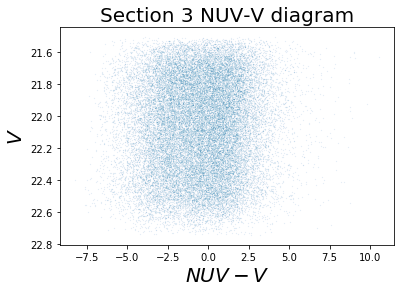

In [16]:
plt.scatter(NUV_magnitude_3 - Vmag_3, Vmag_3, s=0.03,alpha=0.25)
plt.ylim(reversed(plt.ylim()))
plt.xlabel("$NUV-V$", fontsize=20)
plt.ylabel("$V$", fontsize=20)
plt.title("Section 3 NUV-V diagram", fontsize=20)

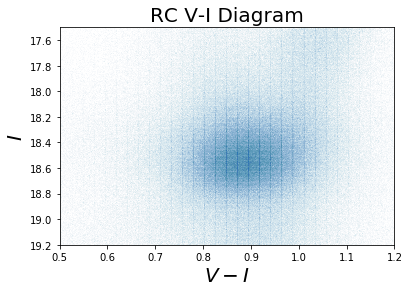

In [17]:
plt.scatter(catalog["Vmag"] - catalog["Imag"], catalog["Imag"], s=0.001, alpha=0.15)
plt.ylim(reversed(plt.ylim()))
plt.xlabel("$V-I$", fontsize=20)
plt.ylabel("$I$", fontsize=20)
plt.xlim(0.5,1.2)
plt.ylim(19.2,17.5)
plt.title("RC V-I Diagram", fontsize=20)

##------------------Trying to locate the Red Clump Stars----------------------------##

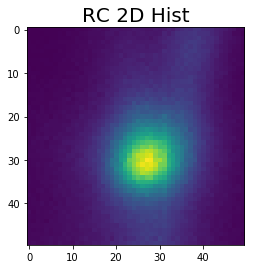

In [60]:
Vmag = catalog["Vmag"]
Imag = catalog["Imag"]
VImag = Vmag - Imag
NaNs1 = np.isnan(VImag)
NaNs2 = np.isnan(Imag)
VImag[NaNs1]= -9999
Imag[NaNs2] = -9999
bins = (50,50)
H, xedges, yedges = np.histogram2d(Imag, VImag, bins, range=[[17.5, 19.2], [0.5, 1.2]])
plt.imshow(H)
plt.title("RC 2D Hist", fontsize=20)

(50, 50)


<a list of 6 text.Text objects>

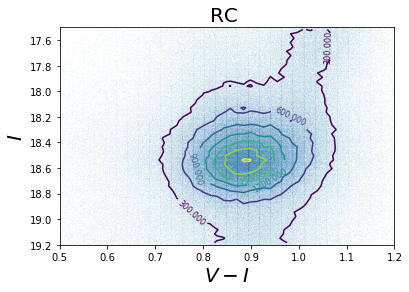

In [62]:
import scipy
from scipy import ndimage
plt.figure(figsize=(8,8))
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.scatter(catalog["Vmag"] - catalog["Imag"], catalog["Imag"], s=0.001, alpha=0.15)
H, xedges, yedges = np.histogram2d(VImag, Imag, bins, range=[[0.5, 1.2], [17.5, 19.2]])
print(H.shape)
extent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
cset1 = ax.contour(H.T,extent=extent,aspect=1,origin='lower')
plt.xlim(0.5,1.2)
plt.ylim(17.5,19.2)
plt.ylim(reversed(plt.ylim()))
plt.xlabel("$V-I$", fontsize=20)
plt.ylabel("$I$", fontsize=20)
plt.title("RC ", fontsize=20)
ax.clabel(cset1, fontsize=8)

In [73]:
points = cset1.collections[1].get_paths()
print(type(points))
dat0= cset1.allsegs[0][0]
points.stat()

#for (elem1, elem2) in points:
    #testList2 += [(elem1, elem2)]
    #x += [elem1]
    #y += [elem2]

#zip(*testList2)
#plt.plot(*zip(*testList2))
#plt.show()

#from numpy.linalg import eig, inv

#def fitEllipse(x,y):
    #x = x[:,np.newaxis]
    #y = y[:,np.newaxis]
    #D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
    #S = np.dot(D.T,D)
    #C = np.zeros([6,6])
    #C[0,2] = C[2,0] = 2; C[1,1] = -1
    #E, V =  eig(np.dot(inv(S), C))
    #n = np.argmax(np.abs(E))
    #a = V[:,n]
    #return a
#fitEllipse()

<class 'list'>


AttributeError: 'list' object has no attribute 'stat'

In [21]:
RC_ra=[]
RC_dec=[]
RC_Vmag=[]
for i in range(0,5156056):
    Vmag = catalog["Vmag"][i]
    Imag = catalog["Imag"][i]
    VImag = Vmag - Imag
    ra = catalog["RAJ2000"][i]
    dec = catalog["DEJ2000"][i]
    if 0.75 < VImag and VImag < 1.05 and 18.17 < Imag and Imag < 18.85:
        RC_ra.append(ra)
        RC_dec.append(dec)
        RC_Vmag.append(Vmag)

RC_loc = Table()
RC_loc['RAJ2000'] = RC_ra
RC_loc['DEJ2000'] = RC_dec

In [22]:
RC_positions = SkyCoord(ra=RC_loc['RAJ2000'] * u.deg, dec=RC_loc['DEJ2000'] * u.deg, frame='fk5')
RC_apertures = SkyCircularAperture(RC_positions, r)
RC_phot_table = aperture_photometry(hdu[0], RC_apertures)
RC_Flux = RC_phot_table['aperture_sum']
NUV_magnitude = -2.5*np.log10(RC_Flux) + 20.08

C:\Users\dougl\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in log10


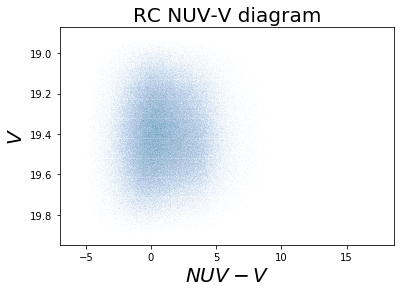

In [23]:

plt.scatter(NUV_magnitude - RC_Vmag, RC_Vmag, s=0.003,alpha=0.07)
plt.ylim(reversed(plt.ylim()))
plt.xlabel("$NUV-V$", fontsize=20)
plt.ylabel("$V$", fontsize=20)
plt.title("RC NUV-V diagram", fontsize=20)


C:\Users\dougl\Anaconda3\lib\site-packages\numpy\lib\function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
C:\Users\dougl\Anaconda3\lib\site-packages\numpy\lib\function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


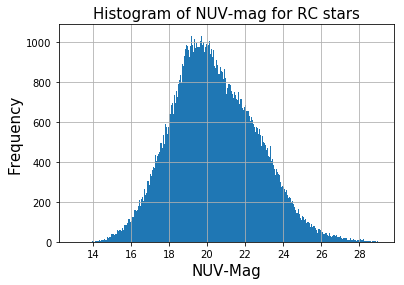

In [24]:
NUV_Mag2 = np.asarray(NUV_magnitude)
NUV_Mag = NUV_Mag2.flatten()
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
plt.hist(NUV_Mag,bins=1000,range=(13,29))
plt.xlabel("NUV-Mag", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title(r'Histogram of NUV-mag for RC stars', fontsize=15)
plt.grid(True)
plt.show()